In [1]:
!pip install --upgrade pip
!pip install jieba
!pip install gensim
!pip install --upgrade numpy # required version newer than 1.17
!pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple


In [ ]:
from __future__ import absolute_import, division, print_function

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch import nn
from torch.autograd import Variable

import numpy as np
import jieba
import gensim
import os
from tqdm import tqdm
from collections import Counter

import math
import matplotlib.pyplot as plt

In [ ]:
# param configuration
DATASET_PATH = 'Dataset.zip'
TRAIN_PATH = './Dataset/train.txt'
VAL_PATH = './Dataset/validation.txt'
TEST_PATH = './Dataset/test.txt'
MODEL_SAVE_PATH = './Model'
MAX_LEN = 50

# model params
VOCAB_SIZE = 58954
NUM_CLASSES = 2
EMB_DIM = 50
HIDDEN_NUM = 256
NUM_FILTERS = 100
K1 = 3
K2 = 4
K3 = 5

# training params
EPOCH = 16
BATCH_SIZE = 32
LR = 0.0001
DROPOUT_RATE = 0.6

In [ ]:
# build word dict: {word: id}
def build_word2id(filepath, save_word2id=None):
    # init the dict
    word2id = {'_PAD_': 0}
    path = [TRAIN_PATH, VAL_PATH]
    
    # build the dict
    for _path in path:
        with open(_path, encoding='utf-8') as f:
            # read line by line
            for line in f.readlines():
                # split a string into a list of strings 
                sp = line.strip().split()
                # skip the first classification label ('0'or'1')
                for word in sp[1:]:
                    if word not in word2id.keys():
                        # append the word into word2id list
                        word2id[word] = len(word2id)
                        
    # save the dict       
    if save_word2id:
        with open(filepath, 'w', encoding='utf-8') as f:
            for w in word2id:
                f.write(w+'\t')
                f.write(str(word2id[w]))
                f.write('\n')
    
    return word2id

In [ ]:
# build word2vec based on pretrained word2vec wiki
def build_word2vec(fname_pretrained, word2id, save_word2vec=None):
    n_words = max(word2id.values()) + 1
    model = gensim.models.KeyedVectors.load_word2vec_format(fname_pretrained, binary=True)
    word_vecs = np.array(np.random.uniform(-1., 1., [n_words, model.vector_size]))
    
    for word in word2id.keys():
        try:
            word_vecs[word2id[word]] = model[word]
        except KeyError:
            pass
        
    if save_word2vec:
        with open(save_to_path, 'w', encoding='utf-8') as f:
            for vec in word_vecs:
                vec = [str(w) for w in vec]
                f.write(' '.join(vec))
                f.write('\n')
    
    return word_vecs

In [ ]:
# load the corpus
def load_corpus(filepath, word2id, max_len=MAX_LEN):
    comments = []
    labels = []
    with open(filepath, encoding='utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            if sp:
                label = sp[0]
                comment = [word2id.get(w, 0) for w in sp[1:]]
                comment = comment[:max_len]
                if len(comment) < max_len:
                    comment += [word2id['_PAD_']] * (max_len - len(comment))
                comments.append(comment)
                labels.append(label)
                        
    counter = Counter(labels)
    print(counter)
    
    texts = np.asarray(comments)
    label_array = np.array([class2id[l] for l in labels])
    return texts, label_array

In [ ]:
# Set up the TextCNN Network
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        # use pretraining word2vec
        self.embedding.weight.data.copy_(torch.from_numpy(word2vec))
        self.embedding.weight.requires_grad = True
        
        # conv layer
        filters = [K1, K2, K3]
        self.cnn = nn.ModuleList([nn.Sequential(
            nn.Conv1d(1, NUM_FILTERS, [k, EMB_DIM]),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1)) for k in filters])
        
        # output layer
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fc = nn.Linear(NUM_FILTERS * 3, NUM_CLASSES, bias=True)
        
    def forward(self, input_):
        input_ = input_.to(torch.int64)
        # embedding layer
        embeds = self.embedding(input_).unsqueeze(1)
        
        # conv layer
        cnn = [conv(embeds) for conv in self.cnn]
        
        # output layer
        output = torch.cat(cnn, 1).squeeze(2).squeeze(2)
        output = self.dropout(output)
        output = self.fc(output)
        
        return output      

In [ ]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    running_loss, running_acc = 0.0, 0.0
    count, correct = 0, 0
    model.train()
    for i, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (output.argmax(1) == y).float().sum().item()
        count += len(x)
    
    running_acc = correct/count
    running_loss = running_loss/len(train_loader)
    print("Epoch: {}/{}.. ".format(epoch, EPOCH),
          "Training Loss: {:.4f}.. ".format(running_loss),
          "Training Acc: {:.2f}%.. ".format(running_acc*100)) 
    return running_loss, running_acc

          
def test(model, device, val_loader, criterion):
    running_loss, running_acc = 0.0, 0.0
    count, correct = 0,0
    model.eval()
    with torch.no_grad():
        for _, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            running_loss += loss.item()
            correct += (output.argmax(1) == y).float().sum().item()
            count += len(x)
    
    running_loss = running_loss/len(train_loader)
    running_acc = correct/count
    print("Testing Loss: {:.4f}.. ".format(running_loss),
          "Testing Acc: {:.2f}%.. ".format(running_acc*100)) 
    return running_loss, running_acc

In [ ]:
# Main training process
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# path to save the model
if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)

# Preps-1: classification category & dict {pos:0, neg:1}
classes = ['0', '1']
class2id = {cat: idx for (idx, cat) in enumerate(classes)}

# Preps-2: word dict and pretrained word2vec
word2id = build_word2id('./Dataset/word2id.txt')
print('[INFO]: Finished setting up the word dict of length %d' %len(word2id))
word2vec = build_word2vec('./Dataset/wiki_word2vec_50.bin', word2id)
print('[INFO]: Finished setting up the word2vec with shape (%d, %d)' %np.shape(word2vec))

[INFO]: Finished setting up the word dict of length 58954
[INFO]: Finished setting up the word2vec with shape (58954, 50)


In [ ]:
# load training, validation and testing corpus
print('[INFO]: Loading the corpus, \'1\': #neg_comments, \'0\': #pos_comments')
print('[INFO]: The training set:')
x_train, y_train = load_corpus(TRAIN_PATH, word2id, MAX_LEN)
print('[INFO]: The validation set:')
x_val, y_val = load_corpus(VAL_PATH, word2id, MAX_LEN)

[INFO]: Loading the corpus, '1': #neg_comments, '0': #pos_comments
[INFO]: The training set:
Counter({'1': 9999, '0': 9999})
[INFO]: The validation set:
Counter({'0': 2817, '1': 2812})


In [ ]:
# load data
train_dataset = TensorDataset(torch.from_numpy(x_train).type(torch.float), 
                              torch.from_numpy(y_train).type(torch.long))
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          num_workers = 2)

val_dataset = TensorDataset(torch.from_numpy(x_val).type(torch.float), 
                            torch.from_numpy(y_val).type(torch.long))
val_loader = DataLoader(dataset = val_dataset, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True, 
                        num_workers = 2)

model = TextCNN().to(device)

# For pretraining
# model.load_state_dict(torch.load('./model/TextCNN.pth', map_location=device))

# Optimizer and loss 
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# begin training
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, EPOCH + 1):
    running_train_loss, running_train_acc = train(model, device, train_loader, optimizer, epoch, criterion)
    running_val_loss, running_val_acc = test(model, device, val_loader, criterion)
    
    train_loss.append(running_train_loss)
    train_acc.append(running_train_acc)
    val_loss.append(running_val_loss)
    val_acc.append(running_val_acc)

    torch.save(model.state_dict(), './Model/TextCNN_epoch{}.pth'.format(epoch))

torch.save(model.state_dict(), './Model/TextCNN.pth')

625it [00:14, 42.20it/s]

Epoch: 1/16..  Training Loss: 0.6609..  Training Acc: 60.07%.. 


Testing Loss: 0.1681..  Testing Acc: 73.53%.. 


625it [00:14, 42.43it/s]

Epoch: 2/16..  Training Loss: 0.5686..  Training Acc: 71.79%.. 


Testing Loss: 0.1474..  Testing Acc: 75.75%.. 


625it [00:14, 42.44it/s]

Epoch: 3/16..  Training Loss: 0.5047..  Training Acc: 75.53%.. 


Testing Loss: 0.1361..  Testing Acc: 77.30%.. 


625it [00:14, 42.32it/s]

Epoch: 4/16..  Training Loss: 0.4630..  Training Acc: 78.54%.. 


Testing Loss: 0.1299..  Testing Acc: 78.54%.. 


625it [00:14, 42.33it/s]

Epoch: 5/16..  Training Loss: 0.4292..  Training Acc: 80.49%.. 


Testing Loss: 0.1259..  Testing Acc: 79.41%.. 


625it [00:14, 42.75it/s]

Epoch: 6/16..  Training Loss: 0.4023..  Training Acc: 81.84%.. 


Testing Loss: 0.1233..  Testing Acc: 79.50%.. 


625it [00:14, 42.20it/s]


Epoch: 7/16..  Training Loss: 0.3814..  Training Acc: 83.20%.. 
Testing Loss: 0.1209..  Testing Acc: 79.73%.. 


625it [00:14, 42.29it/s]

Epoch: 8/16..  Training Loss: 0.3570..  Training Acc: 84.51%.. 


Testing Loss: 0.1189..  Testing Acc: 80.42%.. 


625it [00:14, 42.16it/s]

Epoch: 9/16..  Training Loss: 0.3371..  Training Acc: 85.72%.. 


Testing Loss: 0.1176..  Testing Acc: 80.74%.. 


625it [00:14, 42.78it/s]

Epoch: 10/16..  Training Loss: 0.3158..  Training Acc: 86.75%.. 


Testing Loss: 0.1166..  Testing Acc: 80.81%.. 


625it [00:14, 42.65it/s]

Epoch: 11/16..  Training Loss: 0.2980..  Training Acc: 87.58%.. 


Testing Loss: 0.1161..  Testing Acc: 81.08%.. 


625it [00:14, 42.38it/s]

Epoch: 12/16..  Training Loss: 0.2792..  Training Acc: 88.55%.. 


Testing Loss: 0.1159..  Testing Acc: 81.36%.. 


625it [00:14, 42.33it/s]

Epoch: 13/16..  Training Loss: 0.2601..  Training Acc: 89.40%.. 


Testing Loss: 0.1152..  Testing Acc: 81.58%.. 


625it [00:14, 42.36it/s]

Epoch: 14/16..  Training Loss: 0.2464..  Training Acc: 90.30%.. 


Testing Loss: 0.1154..  Testing Acc: 81.76%.. 


625it [00:14, 42.26it/s]

Epoch: 15/16..  Training Loss: 0.2282..  Training Acc: 91.03%.. 


Testing Loss: 0.1162..  Testing Acc: 82.27%.. 


625it [00:14, 42.55it/s]

Epoch: 16/16..  Training Loss: 0.2144..  Training Acc: 91.68%.. 


Testing Loss: 0.1168..  Testing Acc: 82.50%.. 


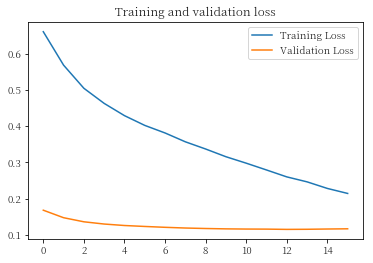

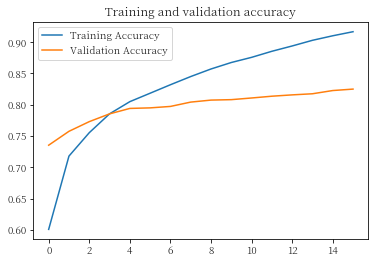

In [ ]:
# evaluate the result
%matplotlib inline
epochs = range(EPOCH)

# plot training & validation accuracy per epoch
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Testing

print('[INFO]: The testing set:')

# load test dataset
x_test, y_test = load_corpus(TEST_PATH, word2id, MAX_LEN)

test_dataset = TensorDataset(torch.from_numpy(x_test).type(torch.float), 
                             torch.from_numpy(y_test).type(torch.long))

test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, 
                            shuffle = False, num_workers = 2)
# load model
model = TextCNN().to(device)
model.load_state_dict(torch.load('./Model/TextCNN.pth'))

# Test the accuracy
count, correct = 0, 0
for _, (x, y) in enumerate(test_loader):
    x, y = x.to(device), y.to(device)
    output = model(x)
    correct += (output.argmax(1) == y).float().sum().item()
    count += len(x)
    
print('test accuracy:{:.2f}%.'.format(100*correct/count))

[INFO]: The testing set:
Counter({'1': 187, '0': 182})
test accuracy:84.82%.
